In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect = True)
# reflect the tables
Base.classes.keys()
# we got two data tables : measurement and station

['measurement', 'station']

In [6]:
# View all of the classes that automap found
# measurement
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [10]:
# 1. Find the most recent date in the data set.
measurement_date = session.query(measurement.id,measurement.date)
measurement_date_recent = measurement_date.order_by(measurement.date.desc()).first()
print(measurement_date_recent[1])

2017-08-23


In [11]:
# 2. Design a query to retrieve the last 12 months of precipitation data and plot the results. Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_later = dt.date(2017,8,23) - dt.timedelta(days = 365)
print(one_year_later)

2016-08-23


In [22]:
# Perform a query to retrieve the data and precipitation scores
for item in session.query(measurement).\
    filter(measurement.date >= '2016-08-23').\
    order_by(measurement.date).limit(20):
    print(item.id,item.station,item.date,item.prcp,item.tobs)


2364 USC00519397 2016-08-23 0.0 81.0
5091 USC00513117 2016-08-23 0.15 76.0
7331 USC00514830 2016-08-23 0.05 80.0
8825 USC00517948 2016-08-23 None 80.0
11851 USC00519523 2016-08-23 0.02 80.0
14608 USC00519281 2016-08-23 1.79 77.0
19202 USC00516128 2016-08-23 0.7 74.0
2365 USC00519397 2016-08-24 0.08 79.0
5092 USC00513117 2016-08-24 2.15 76.0
7332 USC00514830 2016-08-24 2.28 80.0
8826 USC00517948 2016-08-24 None 78.0
11852 USC00519523 2016-08-24 1.22 79.0
14609 USC00519281 2016-08-24 2.15 77.0
19203 USC00516128 2016-08-24 1.45 74.0
2366 USC00519397 2016-08-25 0.08 80.0
5093 USC00513117 2016-08-25 0.08 77.0
7333 USC00514830 2016-08-25 0.0 81.0
8827 USC00517948 2016-08-25 0.0 81.0
11853 USC00519523 2016-08-25 0.21 80.0
14610 USC00519281 2016-08-25 0.06 80.0


In [26]:
# 3. Select only the `date` and `prcp` values.
new_measurement = session.query(measurement.date,measurement.prcp).\
    filter(measurement.date >= '2016-08-23').all()


In [27]:
# 4. Save the query results as a Pandas DataFrame and set the index to the date column
meansurement_df = pd.DataFrame(new_measurement, columns = ['Date','Precipatation'])
meansurement_df = meansurement_df.dropna(how = 'any')
meansurement_df.set_index('Date', inplace = True)


In [28]:
# 5. Sort the dataframe by date
sort_meansurement_df = meansurement_df.sort_values(by = 'Date')
sort_meansurement_df.head(10)

,Precipatation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22
2016-08-24,0.08
2016-08-24,2.15


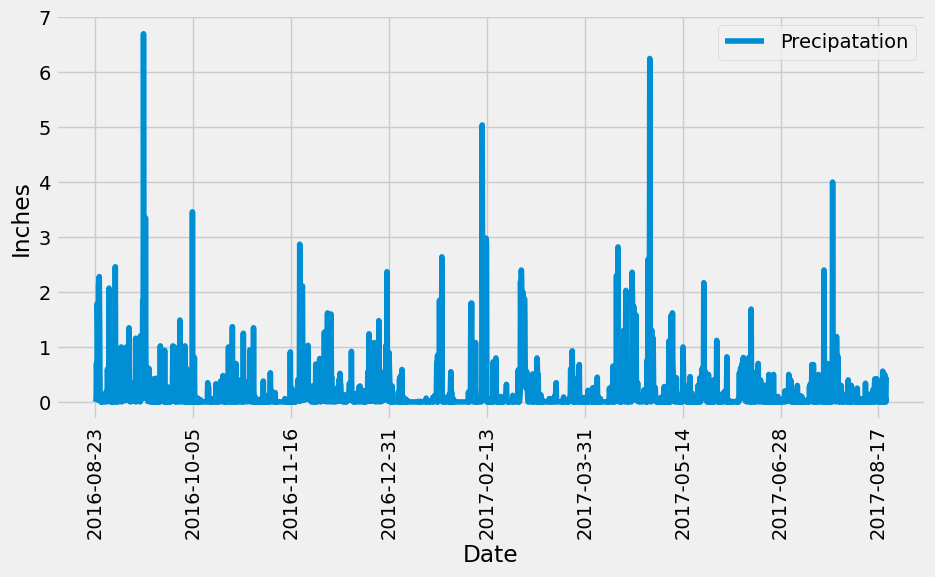

In [31]:
# 6. Use Pandas Plotting with Matplotlib to plot the data
ax = sort_meansurement_df.plot(figsize=(10,5),rot=90);
ax.set_ylabel("Inches");
# plt.savefig("Precipitation Analysis.png")

In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sort_meansurement_df.describe() 

,Precipatation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [33]:
# 1.Design a query to calculate the total number stations in the dataset
session.query(station.station).count()

9

In [46]:
# 2.Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
results = session.query(measurement.station,func.count(measurement.station).label('count number')).\
                        group_by(measurement.station).\
                        order_by(desc('count number')).all()

print(results)
print(f"The most active station is '{results[0][0]}'.")

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
The most active station is 'USC00519281'.


In [48]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result2 = session.query(func.min(measurement.tobs),
                        func.avg(measurement.tobs),
                       func.max(measurement.tobs),
                       func.count(measurement.tobs)).\
        filter(measurement.station == 'USC00519281').all()

print(result2)
print(f"The lowest, highest and average temperature are {round(result2[0][0])},{round(result2[0][1])} and {round(result2[0][2])} respectively.")

[(54.0, 71.66378066378067, 85.0, 2772)]
The lowest, highest and average temperature are 54,72 and 85 respectively.


In [50]:
# 3.Design a query to retrieve the previous 12 months of temperature observation data (TOBS).
# Filter by the station with the highest number of observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result3 = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= '2016-08-23').all()
result3_df = pd.DataFrame(result3)
result3_df.head(10)

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
5,73.0
6,78.0
7,77.0
8,78.0
9,80.0


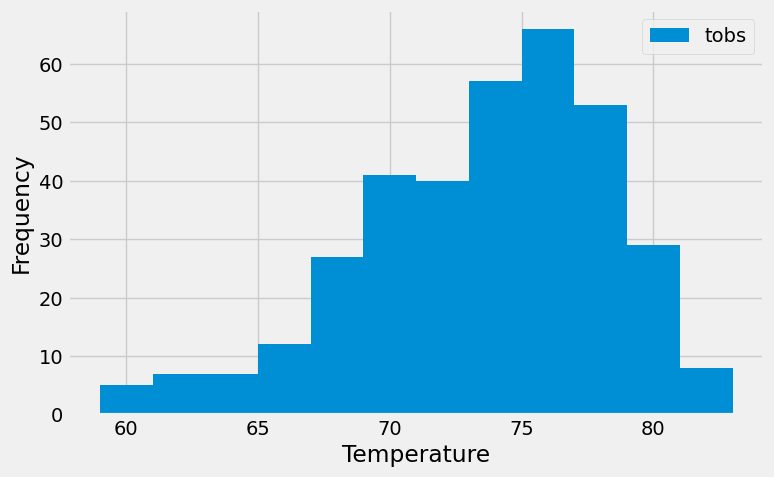

In [20]:
# histogram plot
result3_df.plot.hist(bins=12,label="tobs",figsize=(8,5))
plt.ylim=(0,60)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
#plt.savefig("Temperature_Analysis.png")
plt.show()

# Close session

In [21]:
# Close Session
session.close()